In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

In [2]:
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
import cv2
cap = cv2.VideoCapture(0)

In [4]:
print(sys.path)

['', '/opt/ros/melodic/lib/python2.7/dist-packages', '/home/user1/MyProjects/tf_models/research', '/home/user1/MyProjects/tf_models/research/slim', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/user1/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/home/user1/.local/lib/python3.6/site-packages/IPython/extensions', '/home/user1/.ipython']


In [5]:
get_ipython().magic('matplotlib inline')

In [6]:
%%bash
pwd

/home/user1/MyProjects/tf_models/research/object_detection


In [7]:
sys.path.append("..")

In [8]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [9]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

In [10]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [11]:
print(PATH_TO_LABELS)

data/mscoco_label_map.pbtxt


In [1]:
### Download Model (not needed)
#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
#tar_file = tarfile.open(MODEL_FILE)
#for file in tar_file.getmembers():
#  file_name = os.path.basename(file.name)
#  if 'frozen_inference_graph.pb' in file_name:
#    tar_file.extract(file, os.getcwd())

In [13]:
print(os.getcwd())

/home/user1/MyProjects/tf_models/research/object_detection


In [14]:
### extract frozon inference graph file (done)
#tar_file = tarfile.open(MODEL_FILE)
#for file in tar_file.getmembers():
#    print(file)
#    file_name = os.path.basename(file.name)
#    print(file_name)

<TarInfo 'ssd_mobilenet_v1_coco_11_06_2017' at 0x7f51364f0c00>
ssd_mobilenet_v1_coco_11_06_2017
<TarInfo 'ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.index' at 0x7f51364f0750>
model.ckpt.index
<TarInfo 'ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.meta' at 0x7f51364f05c0>
model.ckpt.meta
<TarInfo 'ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb' at 0x7f51364f0688>
frozen_inference_graph.pb
<TarInfo 'ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.data-00000-of-00001' at 0x7f51364f0818>
model.ckpt.data-00000-of-00001
<TarInfo 'ssd_mobilenet_v1_coco_11_06_2017/graph.pbtxt' at 0x7f51364f08e0>
graph.pbtxt


## Load a (frozen) Tensorflow model into memory.

In [15]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine


In [16]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [21]:
print(1)

1


### Helper code

In [17]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

### Test detection

In [18]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
print(TEST_IMAGE_PATHS[1])

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


test_images/image2.jpg


## Single image detection

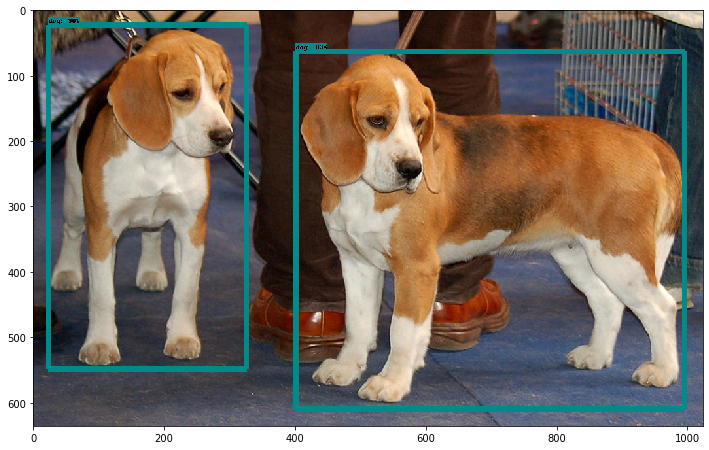

In [33]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image = Image.open(TEST_IMAGE_PATHS[0])
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        # Actual detection.
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

        #cv2.imshow('object detection', cv2.resize(image_np, (800,600)))
        #if cv2.waitKey(25) & 0xFF == ord('q'):
          #cv2.destroyAllWindows()
          #break

## Video stream detection

In [ ]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        
        while True:
            ret, image_np = cap.read()
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)

            cv2.imshow('object detection', cv2.resize(image_np, (800,600)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break